<a href="https://colab.research.google.com/github/GokulNC/NLP-Exercises/blob/master/Transliteration-Indian-Languages/Eng2Hindi_DL_Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the dependencies

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random
# from torchtext.data import Field, BucketIterator


## Data Management

### Alphabets Setup

In [49]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'
start_char = '-SOS-'
end_char = '-EOS-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

eng_alpha2index[start_char] = 27
eng_alpha2index[end_char] = 28
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, '-SOS-': 27, '-EOS-': 28}


In [50]:
# Hindi Unicode Hex Range: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
hindi_index2alpha = {0: pad_char}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1
    hindi_index2alpha[index+1] = alpha

hindi_alpha2index[start_char] = 129
hindi_alpha2index[end_char] = 130
hindi_index2alpha[129] = start_char
hindi_index2alpha[130] = end_char
print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [51]:
array = [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 6, 10, 49, 16, 39, 58, 37, 45, 21, 10, 43, 37, 43, 49, 54, 49, 22, 24,
         24, 22, 58, 43, 22, 11, 57, 16, 29, 16, 48, 16, 25, 39],
        [45, 37, 76, 22, 64, 32, 37, 57, 49, 47, 49, 45, 49, 58, 22, 67, 49, 63,
         48, 66, 66, 49, 49, 43, 47, 22, 49, 22, 58, 22, 32, 72],
        [ 2, 49, 29,  2, 41,  2, 78,  2,  2, 78,  2,  2,  2, 65, 65, 43,  2, 16,
         63, 28, 16,  2,  2, 49, 48,  2, 63,  2,  2,  2,  2, 49],
        [ 0, 65,  2,  0,  2,  0, 54,  0,  0, 49,  0,  0,  0,  2, 51,  2,  0,  2,
          2,  2,  2,  0,  0,  2,  2,  0,  2,  0,  0,  0,  0,  2],
        [ 0,  2,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]

testword = ''
for a in array:
    testword += hindi_index2alpha[a[3]]

print(testword)


ऀएकँ-PAD--PAD-


### Downloading the dataset

In [52]:
## Train data file
!wget -nc -q --show-progress https://github.com/GokulNC/NLP-Exercises/raw/master/Transliteration-Indian-Languages/Original-NEWS2012-data/Training/NEWS2012-Training-EnHi-13937.xml
## Test data file
!wget -nc -q --show-progress https://raw.githubusercontent.com/GokulNC/NLP-Exercises/master/Transliteration-Indian-Languages/Original-NEWS2012-data/Ref/NEWS2012-Ref-EnHi-1000.xml

zsh:1: command not found: wget
zsh:1: command not found: wget


### Helper functions for data pre-processing

In [53]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Returns a list of English words in the given line,
# containing only upper-case letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    # Remove all non-letters
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Returns a list of Hindi words in the given line,
# containing only Hindi characters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    # Remove all non-Hindi chars except space
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    
    return cleaned_line.split()

### Dataset Loading

In [54]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch
    
train_data = TransliterationDataLoader('Original-NEWS2012-data/Training/NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('Original-NEWS2012-data/Training/NEWS2012-Training-EnHi-13937.xml')

### Basic Data Visualization

In [55]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20641
Test Set Size:	 20641

Sample data from train-set:
BABUGARH - बाबूगढ़
CROWNHILL - क्राउनहिल
GONDA - गोंडा
SAMASTIPUR - समस्तीपुर
MILLIE - मिली
MEIN - में
ALLAHABAD - इलाहाबाद
RATNAVALI - रत्नावली
SONI - सोनी
ROBINSON - रॉबिंसन


### Encoding the words

In [74]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep


def input_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros([len(word)+2, 1], dtype=torch.long).to(device)
    letter_index = 0
    rep[letter_index][0] = letter2index[start_char]
    for _, letter in enumerate(word):
        pos = letter2index[letter]
        letter_index +=1
        rep[letter_index][0] = pos
    rep[-1][0] = letter2index[end_char]
    return rep


def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+2, 1], dtype=torch.long).to(device)
    letter_index = 0
    gt_rep[letter_index][0] = letter2index[start_char]
    for _, letter in enumerate(word):
        pos = letter2index[letter]
        letter_index +=1
        gt_rep[letter_index][0] = pos
    gt_rep[-1][0] = letter2index[end_char]
    return gt_rep

eng, hindi = train_data.get_random_sample()
eng_rep = input_rep(eng, eng_alpha2index)
print(eng, eng_rep)

hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, hindi_gt)

OPEN tensor([[27],
        [15],
        [16],
        [ 5],
        [14],
        [28]])
ओपन tensor([[129],
        [ 20],
        [ 43],
        [ 41],
        [130]])


## Network Architecture

### Encoder-Decoder (using GRU)

In [75]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
    
    def forward(self, x):
        # Shape of x is seq_length, N where N is batch size

        embedding = self.dropout(self.embedding(x))
        print("Encoder Model: ")
        print("X shape: ", x.shape)
        print("Embedding shape: ", embedding.shape)
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        print("outputs: ", outputs.shape)
        print("hidden: ", hidden.shape)
        print("cell: ", cell.shape)
        

        return hidden, cell

In [76]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.hidden_Size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden, cell):
        # shape of x is (N) but we want (1, N)
        x = x.unsqueeze(0)
        print("Decoder Model: ")
        print("x: ", x.shape)

        embedding = self.dropout(self.embedding(x))
        #embedding shape: 1, N, embedding_size
        print("embedding: ", embedding.shape)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        #shape of outputs: (1, N, hidden_size)
        print("outputs: ", outputs.shape)
        print("hidden: ", hidden.shape)
        print("cell: ", cell.shape)

        predictions = self.fc(outputs)
        #shape of predictions : (1, N, length_of_vocab)
        print("predictions: ", predictions.shape)

        predictions = predictions.squeeze(0)
        print("predictions: ", predictions.shape)

        return predictions, hidden, cell

In [77]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq,self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]

        target_vocab_size = len(hindi_alpha2index)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device_gpu)
        
        hidden, cell = self.encoder(source)

        x = target[0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)

            outputs[t] = output
            # ouptut is N, hindi_vocab_size
            best_guess = output.argmax(1)

            x = target[t] if random.random() < teacher_force_ratio else best_guess
        
        return outputs


        

In [78]:
#training hyperparameters

num_epochs = 17000

learning_rate = 0.001
batch_size = 64

load_model = False


In [79]:
input_size_encoder = len(eng_alpha2index)
input_size_decoder = len(hindi_alpha2index)
output_size = len(hindi_alpha2index)
encoder_embedding_size = 300
decoder_embedding_size = 300

hidden_size = 1024
num_layers = 1 # 2 for without attention.
encoder_dropout = 0.5
decoder_dropout = 0.5

#Tensorboard

# writer = SummaryWriter(f'runs/Loss_plot')
step = 0
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, test_data),
#     batch_size = batch_size,
#     sort_within_batch = True,
#     sort_key = lambda x: len(x.src),
#     device=device_gpu
# )

encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, encoder_dropout).to(device_gpu)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size,output_size, num_layers, decoder_dropout).to(device_gpu)

model = Seq2Seq(encoder_net, decoder_net).to(device_gpu)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


pad_idx = eng_alpha2index['-PAD-']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)


for epoch in range(num_epochs):

    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    input = input_rep(eng_batch[i], eng_alpha2index, device_gpu)
    gt = gt_rep(hindi_batch[i], hindi_alpha2index, device_gpu)
    inp_data = input.to(torch.int64)
    target = gt

    output = model(inp_data, target)
    #output = tar_len, batch_size, output_size

    #(N, 10) and terget would be (N)

    output = output.reshape(-1, output.shape[2])
    target = target.reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output, target)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    step +=1
        

Encoder Model: 
X shape:  torch.Size([9, 1])
Embedding shape:  torch.Size([9, 1, 300])
outputs:  torch.Size([9, 1, 1024])
hidden:  torch.Size([1, 1, 1024])
cell:  torch.Size([1, 1, 1024])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([1, 1, 1024])
cell:  torch.Size([1, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([1, 1, 1024])
cell:  torch.Size([1, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([1, 1, 1024])
cell:  torch.Size([1, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1,

KeyboardInterrupt: 

In [164]:
def translate_sentence(model, english, hindi, device, max_length=50):
    # print(sentence)

    input = input_rep(english, eng_alpha2index, device_gpu)
    gt = gt_rep(hindi, hindi_alpha2index, device_gpu)

    # # Convert to Tensor
    # sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.encoder(input)

    outputs = [hindi_alpha2index["-PAD-"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == hindi_alpha2index["-EOS-"]:
            break
    print(outputs)
    translated_sentence = [hindi_index2alpha[idx] for idx in outputs]
    hindi_output = ''
    for char in outputs:
        hindi_output += hindi_index2alpha[char]

    # remove start token
    return translated_sentence, hindi_output

In [214]:
english = 'LOVE'
hindi = 'इडेलिया'
device = device_gpu

translate_sentence(model, english, hindi, device, max_length=50)

Encoder Model: 
X shape:  torch.Size([6, 1])
Embedding shape:  torch.Size([6, 1, 300])
outputs:  torch.Size([6, 1, 1024])
hidden:  torch.Size([2, 1, 1024])
cell:  torch.Size([2, 1, 1024])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([2, 1, 1024])
cell:  torch.Size([2, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([2, 1, 1024])
cell:  torch.Size([2, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1, 1, 300])
outputs:  torch.Size([1, 1, 1024])
hidden:  torch.Size([2, 1, 1024])
cell:  torch.Size([2, 1, 1024])
predictions:  torch.Size([1, 1, 131])
predictions:  torch.Size([1, 131])
Decoder Model: 
x:  torch.Size([1, 1])
embedding:  torch.Size([1,

(['-PAD-', 'ल', 'ो', 'व', '-EOS-'], '-PAD-लोव-EOS-')

In [49]:
def infer(net, word, char_limit, device = 'cpu'):
    input = input_rep(word, eng_alpha2index, device)
    return net(input, char_limit)

def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

In [50]:
test(model, 'DIKHSHA')

AttributeError: 'int' object has no attribute 'shape'

In [86]:
#Attention:

class EncoderAttn(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(EncoderAttn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [87]:
# class DecoderAttn(nn.Module):
#     def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
#         super(DecoderAttn, self).__init__()
#         self.hidden_Size = hidden_size
#         self.num_layers = num_layers
#         self.dropout = nn.Dropout(p)
#         self.embedding = nn.Embedding(input_size, embedding_size)
#         self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers, dropout=p)
#         self.energy = nn.Linear(hidden_size * 3, 1)
#         self.softmax = nn.Softmax(dim=0)
#         self.relu = nn.ReLU()
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x, encoder_state, hidden, cell):
#         # shape of x is (N) but we want (1, N)
#         x = x.unsqueeze(0)

#         embedding = self.dropout(self.embedding(x))
#         #embedding shape: 1, N, embedding_size
#         sequence_length = encoder_state.shape[0]
#         h_reshaped = hidden.repeat(sequence_length, 1, 1)
#         energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_state), dim=2)))
#         attention = self.softmax(energy)
#         # attention: seq_len, N, 1
#         #Encoder states: (N, )
#         attention = attention.permute(1, 2, 0)
#         #(N, 1, seq_len)
#         encoder_states = encoder_state.permute(1, 0, 2)
        
#         context_vector = torch.bmm(attention, encoder_states).permute(1, 0, 2)
#         rnn_input = torch.cat((context_vector, embedding), dim=2)
        
#         outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
#         #shape of outputs: (1, N, hidden_size)
#         # print("outputs: ", outputs.shape)
#         # print("hidden: ", hidden.shape)
#         # print("cell: ", cell.shape)

#         predictions = self.fc(outputs)
#         # #shape of predictions : (1, N, length_of_vocab)
#         # print("predictions: ", predictions.shape)

#         predictions = predictions.squeeze(0)
#         # print("predictions: ", predictions.shape)
#         return predictions, hidden, cell

In [88]:
class DecoderAttn(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(DecoderAttn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)

        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)

        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)

        # attention: (seq_length, N, 1), snk
        # encoder_states: (seq_length, N, hidden_size*2), snl
        # we want context_vector: (1, N, hidden_size*2), i.e knl
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [89]:
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(hindi_alpha2index)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device_gpu)
        encoder_states, hidden, cell = self.encoder(source)

        # First input will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [90]:
# class Seq2SeqAttn(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Seq2SeqAttn,self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, source, target, teacher_force_ratio=0.5):
#         batch_size = source.shape[1]
#         target_len = target.shape[0]

#         target_vocab_size = len(hindi_alpha2index)

#         outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device_gpu)
        
#         encoder_states, hidden, cell = self.encoder(source)

#         x = target[0]

#         for t in range(1, target_len):
#             output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

#             outputs[t] = output
#             # ouptut is N, hindi_vocab_size
#             best_guess = output.argmax(1)

#             x = target[t] if random.random() < teacher_force_ratio else best_guess
        
#         return outputs


        

Iteration 11859 Loss 0.8920754194259644


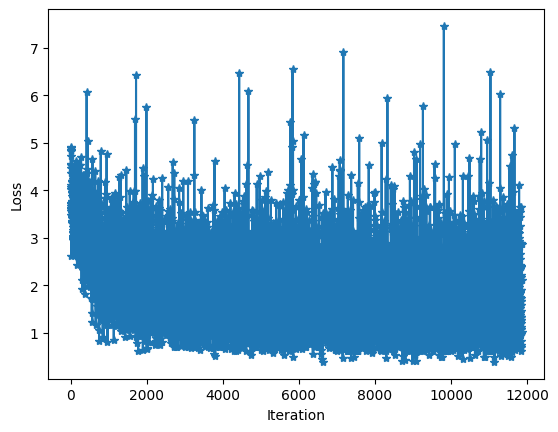

KeyboardInterrupt: 

In [96]:
#training hyperparameters

num_epochs = 17000

learning_rate = 0.001
batch_size = 64

load_model = False


input_size_encoder = len(eng_alpha2index)
input_size_decoder = len(hindi_alpha2index)
output_size = len(hindi_alpha2index)
encoder_embedding_size = 300
decoder_embedding_size = 300

hidden_size = 1024
num_layers = 1 # 2 for without attention.
encoder_dropout = 0.5
decoder_dropout = 0.5

#Tensorboard

# writer = SummaryWriter(f'runs/Loss_plot')
step = 0
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, test_data),
#     batch_size = batch_size,
#     sort_within_batch = True,
#     sort_key = lambda x: len(x.src),
#     device=device_gpu
# )

encoderAttn_net = EncoderAttn(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, encoder_dropout).to(device_gpu)
decoderAttn_net = DecoderAttn(input_size_decoder, decoder_embedding_size, hidden_size,output_size, num_layers, decoder_dropout).to(device_gpu)

model = Seq2SeqAttn(encoderAttn_net, decoderAttn_net).to(device_gpu)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


pad_idx = eng_alpha2index['-PAD-']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

loss_arr = []
for epoch in range(num_epochs):
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    input = input_rep(eng_batch[i], eng_alpha2index, device_gpu)
    gt = gt_rep(hindi_batch[i], hindi_alpha2index, device_gpu)
    inp_data = input.to(torch.int64)
    target = gt
    output = model(inp_data, target)
    #output = tar_len, batch_size, output_size

    #(N, 10) and terget would be (N)

    output = output.reshape(-1, output.shape[2])
    target = target.reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output, target)
    loss_arr.append(loss.item())
    loss.backward()
    display_freq=5
    if epoch%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', epoch, 'Loss', loss.item())
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:epoch], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    step +=1
        

In [99]:
def translate_sentence(model, english, hindi, device, max_length=50):
    # print(sentence)

    input = input_rep(english, eng_alpha2index, device_gpu)
    gt = gt_rep(hindi, hindi_alpha2index, device_gpu)

    # # Convert to Tensor
    # sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        encoder_states, hidden, cell = model.encoder(input)

    outputs = [hindi_alpha2index["-PAD-"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, encoder_states, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == hindi_alpha2index["-EOS-"]:
            break
    print(outputs)
    translated_sentence = [hindi_index2alpha[idx] for idx in outputs]
    hindi_output = ''
    for char in outputs:
        hindi_output += hindi_index2alpha[char]

    # remove start token
    return translated_sentence, hindi_output

english = 'LOVE'
hindi = 'इडेलिया'
device = device_gpu

translate_sentence(model, english, hindi, device, max_length=50)

In [119]:
english = 'BAIRATHI'
hindi = 'इडेलिया'
device = device_gpu

translate_sentence(model, english, hindi, device, max_length=50)

[0, 45, 73, 49, 63, 48, 63, 130]


(['-PAD-', 'ब', 'ै', 'र', 'ा', 'य', 'ा', '-EOS-'], '-PAD-बैराया-EOS-')

In [15]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transliteration_EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        out, hidden = self.encoder_rnn_cell(input)
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        for i in range(max_output_chars):
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            # Get OHE from Softmax: https://discuss.pytorch.org/t/softmax-to-one-hot/37302
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()
            
        return outputs

### Encoder-Decoder with Attention (Type 1)
(mechanism based on [PyTorch Docs](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html))

In [16]:
MAX_ENCODER_STEPS = 30

class Transliteration_EncoderDecoderAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_encoder_steps = MAX_ENCODER_STEPS):
        super(Transliteration_EncoderDecoderAttention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.max_encoder_steps = max_encoder_steps
        self.attn = nn.Linear(self.hidden_size * 2, max_encoder_steps)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)
        
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        out, hidden = self.encoder_rnn_cell(input)
        decoder_state = hidden
        
        encoder_outputs = torch.zeros(self.max_encoder_steps, self.hidden_size, device=device)
        for i in range(out.shape[0]):
            encoder_outputs[i] = out[i, 0]
        
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        for i in range(max_output_chars):
            embedding = self.out2hidden(decoder_input)
            attn_weights = F.softmax(
                self.attn(torch.cat((embedding[0], decoder_state[0]), 1)), dim=1)
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1)
            decoder_input = self.attn_combine(decoder_input).unsqueeze(0)
            decoder_input = F.relu(decoder_input)
            
            
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            # Get OHE from Softmax: https://discuss.pytorch.org/t/softmax-to-one-hot/37302
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device = device)
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()
            
        return outputs

### Encoder-Decoder with Attention (Type 2)
(mechanism based on [Mitesh's lectures on Attention](https://www.cse.iitm.ac.in/~miteshk/CS7015_2018.html))

In [17]:
class Transliteration_EncoderDecoderAttention_Type2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transliteration_EncoderDecoderAttention_Type2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)
        
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        decoder_state = hidden
        
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        U = self.U(encoder_outputs)
        
        for i in range(max_output_chars):
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            # Get OHE from Softmax: https://discuss.pytorch.org/t/softmax-to-one-hot/37302
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) # In dim 2, set max_idx's as 1
            decoder_input = one_hot.detach()
            
        return outputs

## Training

### Core Trainer

In [18]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

### Training Helper

In [19]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    #print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
    torch.save(net, 'model.pt')
    return loss_arr

### Training without Attention

In [20]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 1999 Loss 0.1844225972890854


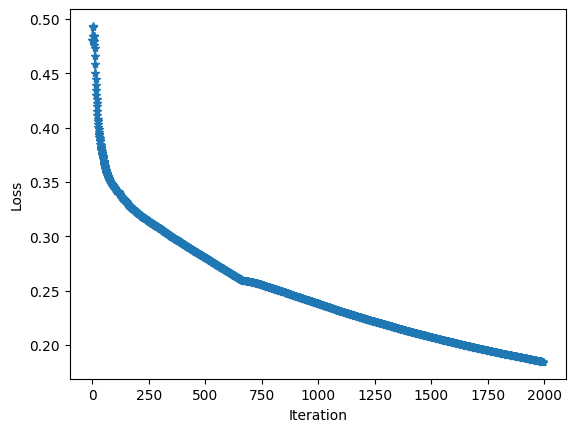

array([0.        , 0.48061725, 0.49358338, ..., 0.18447448, 0.1844226 ,
       0.18437725])

In [21]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

### Training with Attention Type 1

In [22]:
net2 = Transliteration_EncoderDecoderAttention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 2049 Loss 0.1293310672044754


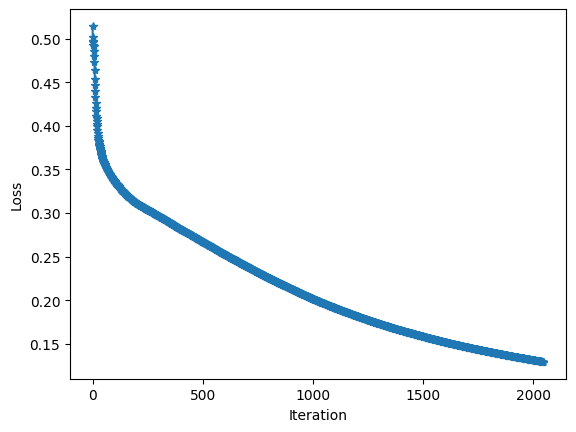

KeyboardInterrupt: 

In [23]:
loss_history = train_setup(net2, lr=0.001, n_batches=20000, batch_size = 64, display_freq=10, device = device_gpu)

### Training with Attention Type 2 (Mitesh)

In [ ]:
net3 = Transliteration_EncoderDecoderAttention_Type2(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 10579 Loss 0.04278186336159706


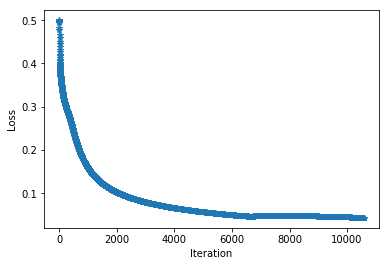

In [ ]:
loss_history = train_setup(net3, lr=0.001, n_batches=20000, batch_size = 64, display_freq=10, device = device_gpu)

## Inference

In [24]:
def infer(net, word, char_limit, device = 'cpu'):
    input = word_rep(word, eng_alpha2index, device)
    return net(input, char_limit)

def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

# hindi_word = test(net2, 'HELLO')

accuracy = calc_accuracy(net2) * 100

print('Accuracy: ', accuracy)

Accuracy:  76.81305912121913


In [41]:
test(net, 'DIKHSHA')

DIKHSHA - नुहॏघी


'नुहॏघी'